## Install necessary libraries

In [1]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 4.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install gensim

     |████████████████████████████████| 24.2 MB 4.3 MB/s eta 0:00:01     |█████████████████████▉          | 16.5 MB 4.3 MB/s eta 0:00:02
     |████████████████████████████████| 113 kB 69.5 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=f53d9310a9dc5a4f88975a385f2e8dd6453cf22d64d3f8c79283efa45d4359d7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/88/2a/d4/f2e9023989d4d4b3574f268657cb6cd23994665a038803f547
Successfully built smart-open
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install imbalanced-learn

     |████████████████████████████████| 167 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 17.1 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


## Import necessary libraries

In [4]:
import numpy as np
import pandas as pd
import boto3
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import warnings
warnings.filterwarnings("ignore")
#from keras.preprocessing import sequence

Using TensorFlow backend.


In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7809921742478577385,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16883381313458741494
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16827798099625653674
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11338085172
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17835025452877259770
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

## Read tidy data into pandas dataframe

In [5]:
# Read the tidy (lemmatized) data into pandas dataframe
client = boto3.client('s3')
path = 's3://bauka-big-tweets/lemmatized.json'
df= pd.read_json(path, orient='table')

## Tag the tweets with labels (positive/negative)

In [6]:
df.head()

,text,lemmatized,tokens_back_to_text
0,"[rudygiuliani, competing, town, halls, joke, s...","[rudygiuliani, compete, town, hall, joke, step...",rudygiuliani compete town hall joke stephanopo...
1,"[trump, machismo]","[trump, machismo]",trump machismo
2,"[briantylercohen, biden, like, encyclopedia, t...","[briantylercohen, biden, like, encyclopedia, t...",briantylercohen biden like encyclopedia tonigh...
3,"[bradleywhitford, yo, semites, qanon, hate, de...","[bradleywhitford, yo, semite, qanon, hate, dem...",bradleywhitford yo semite qanon hate democrat ...
4,"[actbrigitte, president, trump, debate]","[actbrigitte, president, trump, debate]",actbrigitte president trump debate


In [7]:
tweets = list(df['tokens_back_to_text'])
type(tweets)

list

In [8]:
len(tweets)

407766

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sid = SentimentIntensityAnalyzer()
sentiment = [sid.polarity_scores(tweet) for tweet in tweets]
len(sentiment)

407766

In [10]:
sentiments = pd.DataFrame(sentiment, index = df.index)
sentiments.shape

(407766, 4)

In [11]:
sentiments.head()

,neg,neu,pos,compound
0,0.000,0.722,0.278,0.5000
1,0.000,1.000,0.000,0.0000
2,0.000,0.667,0.333,0.5423
3,0.552,0.448,0.000,-0.9022
4,0.000,1.000,0.000,0.0000


In [12]:
sentiments.isnull().sum()

neg         0
neu         0
pos         0
compound    0
dtype: int64

In [13]:
compound = sentiments[['compound']].values

In [14]:
# Tag the tweets with labels using k-means clustering algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(compound)
labels = pd.DataFrame(kmeans.labels_, columns=['label'], index=df.index)
labels.head()

,label
0,1
1,1
2,1
3,0
4,1


In [15]:
labels['label'].value_counts()

1    280321
0    127445
Name: label, dtype: int64

## Feature extraction

In [16]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [17]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 65125 unique tokens.


In [18]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(tweets)

In [19]:
# pad documents to a max length of 14 words
maxlen = 14
X = pad_sequences(sequences, maxlen=maxlen)

In [20]:
X.shape

(407766, 14)

## SMOTE - balance the imbalanced dataset

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, labels['label'])

In [22]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({1: 175200, 0: 140160})


In [23]:
# One-hot encoding of labels
from keras.utils.np_utils import to_categorical
y = to_categorical(y)

## Split the dataset into training and test sets

In [24]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((220752, 14), (94608, 14), (220752, 2), (94608, 2))

## Modeling - Simple RNN and LSTM

In [26]:
# Prepare hyperparameters of RNN
vocab_size = len(word_index)+1
output_dim = 32

In [28]:
# SimpleRNN
warnings.filterwarnings("ignore")
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim=output_dim))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 32)            2084032   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 14, 32)            2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 14, 32)            2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total para

In [33]:
start = time.time()

# Fit the model to the training set
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Train on 154526 samples, validate on 66226 samples
Epoch 1/10
154526/154526 [==============================] - 202s 1ms/step - loss: 0.2016 - acc: 0.9202 - val_loss: 0.1544 - val_acc: 0.9487
Epoch 2/10
154526/154526 [==============================] - 195s 1ms/step - loss: 0.1370 - acc: 0.9521 - val_loss: 0.1483 - val_acc: 0.9488
Epoch 3/10
154526/154526 [==============================] - 194s 1ms/step - loss: 0.1350 - acc: 0.9529 - val_loss: 0.1404 - val_acc: 0.9519
Epoch 4/10
154526/154526 [==============================] - 194s 1ms/step - loss: 0.1345 - acc: 0.9531 - val_loss: 0.1632 - val_acc: 0.9440
Epoch 5/10
154526/154526 [==============================] - 194s 1ms/step - loss: 0.1350 - acc: 0.9534 - val_loss: 0.1486 - val_acc: 0.9481
Epoch 6/10
154526/154526 [==============================] - 194s 1ms/step - loss: 0.1338 - acc: 0.9537 - val_loss: 0.1421 - val_acc: 0.9520
Epoch 7/10
154526/154526 [==============================] - 194s 1ms/step - loss: 0.1327 - acc: 0.9539 - val_

In [44]:
# Save the LSTM model
model.save('srnn.h5')

In [34]:
# LSTM
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim=output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 32)            2084032   
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total para

In [40]:
# Save the LSTM model
model.save('lstm.h5')

In [41]:
start = time.time()

# Fit the model to the training set
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Final evaluation of the model
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Train on 154526 samples, validate on 66226 samples
Epoch 1/10
154526/154526 [==============================] - 418s 3ms/step - loss: 0.1038 - acc: 0.9634 - val_loss: 0.1088 - val_acc: 0.9626
Epoch 2/10
154526/154526 [==============================] - 418s 3ms/step - loss: 0.1030 - acc: 0.9640 - val_loss: 0.1112 - val_acc: 0.9618
Epoch 3/10
154526/154526 [==============================] - 419s 3ms/step - loss: 0.1031 - acc: 0.9638 - val_loss: 0.1114 - val_acc: 0.9617
Epoch 4/10
154526/154526 [==============================] - 418s 3ms/step - loss: 0.1014 - acc: 0.9645 - val_loss: 0.1060 - val_acc: 0.9641
Epoch 5/10
154526/154526 [==============================] - 418s 3ms/step - loss: 0.0993 - acc: 0.9652 - val_loss: 0.1094 - val_acc: 0.9621
Epoch 6/10
154526/154526 [==============================] - 418s 3ms/step - loss: 0.0993 - acc: 0.9655 - val_loss: 0.1114 - val_acc: 0.9624
Epoch 7/10
154526/154526 [==============================] - 418s 3ms/step - loss: 0.0983 - acc: 0.9658 - val_

In [137]:
!nvidia-smi

Tue Nov 10 00:00:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P0    71W / 149W |  10963MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Model Evaluation

### SimpleRNN Result

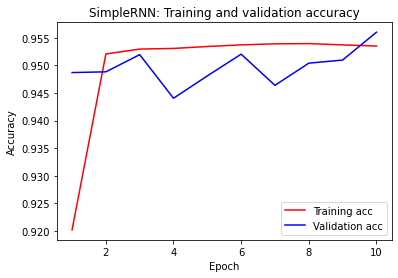

In [34]:
import matplotlib.pyplot as plt
acc = rnn_hist.history['acc']
val_acc = rnn_hist.history['val_acc']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('SimpleRNN: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

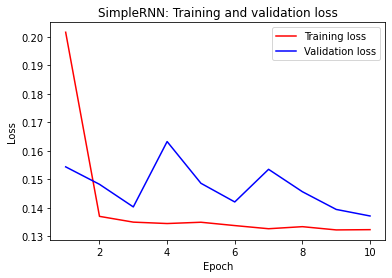

In [35]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('SimpleRNN: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

### LSTM Result

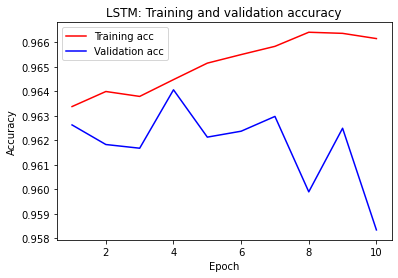

In [44]:
import matplotlib.pyplot as plt
acc = lstm_hist.history['acc']
val_acc = lstm_hist.history['val_acc']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

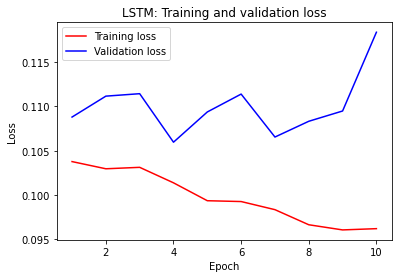

In [45]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

## Predict with the LSTM model

In [36]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [37]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 32)            2084032   
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total para

In [38]:
predictions = lstm.predict(X_test)

In [31]:
probability_positive = predictions[:,1]

In [32]:
len(probability_positive)

94608

In [33]:
probability_positive

array([0.00303076, 0.19198489, 0.964024  , ..., 0.78792804, 0.99388134,
       0.00682921], dtype=float32)

## Conclusion

In this project, I attempted to demonstrate how to set up a deep learning pipeline that predicts the sentiments of the tweets related to the 2020 US election. To do that, I first created my own dataset by scraping raw tweets via Twitter API and Tweepy package. Over 440,000 tweets were streamed via Twitter API and stored into a CSV file. After wrangling and visualizing the data, a traditional clustering algorithm, k-means clustering in this case, was used to tag the tweets with two different labels, representing positive or negative sentiments. That is, the problem was converted into a supervised learning problem before training the deep learning models with the data. Then the dataset was split into training and test sets. Later, the training set was used to train SimpleRNN and LSTM models respectively and were evaluated using the loss and accuracy curves from the model performances in each epoch. Overall, both models appear to be performing well but they are likely to be overfitting the data according as per the accuracy plots and as such I suggest the following recommendations for the next step.

Recommended next steps:

- Find another approach or different clustering algorithms to label the dataset
- Try Amazon sagemaker labeling algorithms to label the dataset
- Try different RNN architectures 
- Perform more advanced tuning of the hyperparameters of the RNN architectures
- Perform cross-validation
- Make the data multi-class problem 

## Skills practiced during this project 
1. How to efficiently collect data from Tweeter via Tweepy and Tweeter  API
2. How to work with big data:

        a. How to export data to JSON and read from JSON
    
        b. How to efficiently read and clean unstructured large text data
    
        c. How to set up and use PySpark on Amazon EMR
    
        d. How to set up and use AWS EC2 instance with Deep Learning AMI
    
        e. How to train deep learning model using Amazon Sagemaker GPU instance
    
    
3. How to build Deep learning (RNN, LSTM) architecture, compile and fit model with Keras
4. How to apply NLP concepts and techniques to text data